🚀 Iniciando análise do dataset...
🔍 Analisando estrutura do arquivo ZIP...
📁 Encontrados 36288 arquivos de labels
🖼️ Encontrados 36768 arquivos de imagens
⚠️ Arquivo de classes não encontrado, usando IDs numéricos


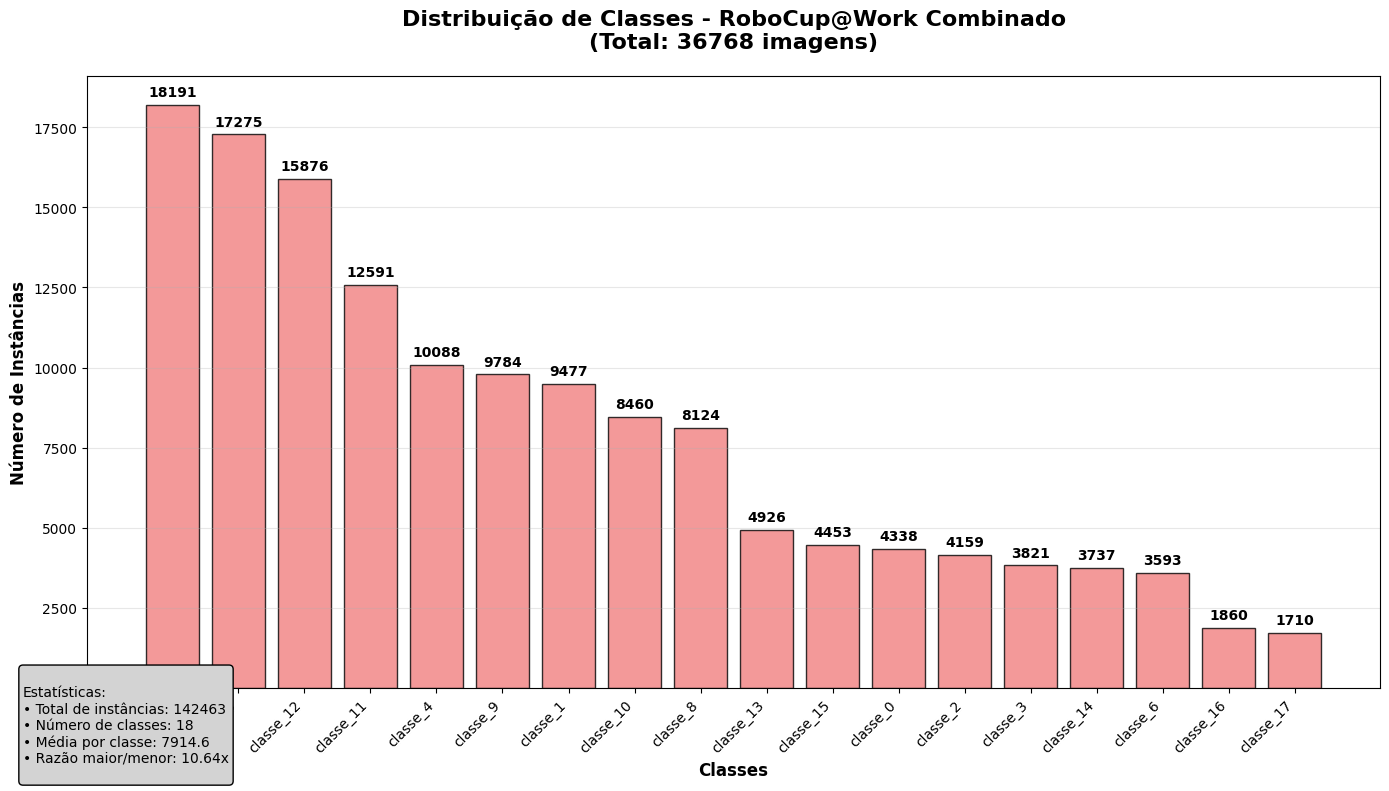


📊 ESTATÍSTICAS DETALHADAS DO DATASET
📁 Total de imagens: 36768
🏷️ Total de instâncias: 142463
📦 Número de classes: 18

📈 Distribuição por classe:
----------------------------------------
         classe_7: 18191 instâncias ( 12.8%) - 0.49/imagem
         classe_5: 17275 instâncias ( 12.1%) - 0.47/imagem
        classe_12: 15876 instâncias ( 11.1%) - 0.43/imagem
        classe_11: 12591 instâncias (  8.8%) - 0.34/imagem
         classe_4: 10088 instâncias (  7.1%) - 0.27/imagem
         classe_9: 9784 instâncias (  6.9%) - 0.27/imagem
         classe_1: 9477 instâncias (  6.7%) - 0.26/imagem
        classe_10: 8460 instâncias (  5.9%) - 0.23/imagem
         classe_8: 8124 instâncias (  5.7%) - 0.22/imagem
        classe_13: 4926 instâncias (  3.5%) - 0.13/imagem
        classe_15: 4453 instâncias (  3.1%) - 0.12/imagem
         classe_0: 4338 instâncias (  3.0%) - 0.12/imagem
         classe_2: 4159 instâncias (  2.9%) - 0.11/imagem
         classe_3: 3821 instâncias (  2.7%) - 0.10/im

In [2]:
import zipfile
import os
import matplotlib.pyplot as plt
import collections
import pandas as pd

def analyze_yolo_from_zip(zip_path):
    """
    Analisa a distribuição de classes diretamente de um arquivo ZIP
    """
    class_counts = collections.Counter()
    total_images = 0
    total_labels = 0

    print("🔍 Analisando estrutura do arquivo ZIP...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar conteúdo do ZIP
        file_list = zip_ref.namelist()

        # Encontrar pastas de labels
        label_folders = [f for f in file_list if 'labels/' in f and f.endswith('.txt')]
        image_folders = [f for f in file_list if 'images/' in f and f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        print(f"📁 Encontrados {len(label_folders)} arquivos de labels")
        print(f"🖼️ Encontrados {len(image_folders)} arquivos de imagens")

        # Tentar encontrar arquivo de classes
        class_files = [f for f in file_list if 'classes.txt' in f or 'names.txt' in f]
        class_names = []

        if class_files:
            with zip_ref.open(class_files[0]) as f:
                class_names = [line.decode('utf-8').strip() for line in f]
            print(f"📋 Classes encontradas: {class_names}")
        else:
            print("⚠️ Arquivo de classes não encontrado, usando IDs numéricos")

        # Processar cada arquivo de labels
        for label_file in label_folders:
            try:
                with zip_ref.open(label_file) as f:
                    lines = f.readlines()
                    total_labels += 1

                    for line in lines:
                        line_decoded = line.decode('utf-8').strip()
                        parts = line_decoded.split()
                        if parts:
                            class_id = int(parts[0])
                            if class_names and class_id < len(class_names):
                                class_name = class_names[class_id]
                            else:
                                class_name = f"classe_{class_id}"
                            class_counts[class_name] += 1

            except Exception as e:
                print(f"Erro ao processar {label_file}: {e}")

    return class_counts, class_names, len(image_folders)

def plot_class_distribution(class_counts, dataset_name, total_images):
    """
    Plota a distribuição de classes com estatísticas
    """
    if not class_counts:
        print("❌ Nenhum dado encontrado para plotar")
        return

    # Ordenar por quantidade
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    # Criar figura
    plt.figure(figsize=(14, 8))

    # Gráfico de barras
    bars = plt.bar(classes, counts, color='lightcoral', edgecolor='black', alpha=0.8)

    # Adicionar valores nas barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold')

    plt.title(f'Distribuição de Classes - {dataset_name}\n(Total: {total_images} imagens)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Classes', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Instâncias', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Adicionar estatísticas no gráfico
    total_instances = sum(counts)
    stats_text = f"""
Estatísticas:
• Total de instâncias: {total_instances}
• Número de classes: {len(classes)}
• Média por classe: {total_instances/len(classes):.1f}
• Razão maior/menor: {max(counts)/min(counts):.2f}x
    """
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.tight_layout()
    plt.show()

    return total_instances, classes, counts

def print_detailed_stats(class_counts, total_images, total_instances):
    """
    Imprime estatísticas detalhadas no console
    """
    print(f"\n{'='*50}")
    print("📊 ESTATÍSTICAS DETALHADAS DO DATASET")
    print(f"{'='*50}")
    print(f"📁 Total de imagens: {total_images}")
    print(f"🏷️ Total de instâncias: {total_instances}")
    print(f"📦 Número de classes: {len(class_counts)}")

    print(f"\n📈 Distribuição por classe:")
    print("-" * 40)

    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

    for class_name, count in sorted_classes:
        percentage = (count / total_instances) * 100
        instances_per_image = count / total_images if total_images > 0 else 0
        print(f"  {class_name:>15}: {count:>4} instâncias ({percentage:>5.1f}%) - {instances_per_image:.2f}/imagem")

    # Estatísticas de balanceamento
    counts = [count for _, count in sorted_classes]
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

    print(f"\n⚖️ ANÁLISE DE BALANCEAMENTO:")
    print(f"  • Classe mais frequente: {sorted_classes[0][0]} ({max_count} instâncias)")
    print(f"  • Classe menos frequente: {sorted_classes[-1][0]} ({min_count} instâncias)")
    print(f"  • Razão de desbalanceamento: {imbalance_ratio:.2f}x")

    # Avaliação qualitativa
    if imbalance_ratio < 3:
        balance_status = "✅ BEM BALANCEADO"
    elif imbalance_ratio < 10:
        balance_status = "⚠️  MODERADAMENTE DESBALANCEADO"
    else:
        balance_status = "❌ FORTEMENTE DESBALANCEADO"

    print(f"  • Status: {balance_status}")

# EXECUTAR ANÁLISE
try:
    zip_path = "/content/drive/MyDrive/Colab Notebooks/robocup-v1-18.zip"

    print("🚀 Iniciando análise do dataset...")
    class_counts, class_names, total_images = analyze_yolo_from_zip(zip_path)

    if class_counts:
        total_instances, classes, counts = plot_class_distribution(
            class_counts,
            "RoboCup@Work Combinado",
            total_images
        )

        print_detailed_stats(class_counts, total_images, total_instances)

        # CONCLUSÃO PARA SUA APRESENTAÇÃO
        print(f"\n{'='*60}")
        print("🎯 CONCLUSÃO PARA SUA APRESENTAÇÃO:")
        print(f"{'='*60}")
        print("• Dataset combinado do Roboflow contém:")
        print(f"  - {total_images} imagens")
        print(f"  - {total_instances} instâncias rotuladas")
        print(f"  - {len(class_counts)} classes distintas")
        print(f"• Razão de desbalanceamento: {max(counts)/min(counts):.1f}x")
        print("\n✅ DECISÃO JUSTIFICADA:")
        print("  Optamos por manter a distribuição original por:")
        print("  1. Preservar a distribuição real do cenário RoboCup")
        print("  2. Evitar overfitting de técnicas artificiais")
        print("  3. Manter integridade dos dados curados do Roboflow")

    else:
        print("❌ Nenhuma anotação foi encontrada no arquivo ZIP")

except FileNotFoundError:
    print(f"❌ Arquivo não encontrado: {zip_path}")
    print("💡 Verifique se o caminho está correto e se o arquivo existe")
except Exception as e:
    print(f"❌ Erro durante a análise: {e}")